In [346]:
library('tidyverse')
library('repr')

### Load + process data

+ jail_county_df.csv
+ demographic data: https://github.com/ringhilterra/enriched-covid19-data
+ county land area: https://github.com/ykzeng/covid-19/tree/master/data

In [391]:
# load datasets

# --------------
# from jessica:
# jail_county_df, without the index column X
jail_county_df <- read.csv('jail_county_df.csv', stringsAsFactors = FALSE)[ , 2:10]

# prison_county_df, without the index column X
prison_county_df <- read.csv('prison_county_df.csv', stringsAsFactors = FALSE)[ , 2:7]
#  capitalize county name:
prison_county_df$county <- str_to_title(prison_county_df$county)

# nytimes
#us_counties <- read.csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
# vera inst
#jail_population <- read.csv('https://raw.githubusercontent.com/vera-institute/jail-population-data/master/jail_population.csv')


# merge with demographics datasets

# --------------
# county demographics: 
#   https://github.com/ringhilterra/enriched-covid19-data
county_demographics_df <- read.csv('https://raw.githubusercontent.com/ringhilterra/enriched-covid19-data/master/us_county_demographics.csv', stringsAsFactors = FALSE)

#  tidy up column names: convert to lower case
names(county_demographics_df) <- str_to_lower(names(county_demographics_df))
#  remove word "county" from county column
county_demographics_df$county <- sub(county_demographics_df$county, pattern = " [[:alpha:]]*$", replacement = "")

# -------------- 
# clean up county_demographic_df
#  note: county populations from this dataset is similar but not the same as nytimes/vera inst.
#   We'll use just the other columns (race/ethnicity, age, gender, etc.)
county_demographics_df <- county_demographics_df[ , c(4, 3, 5:21)]
            
# compute age group percentages instead of count, and
#  add lowrisk_agegroup_perc and highrisk_agegroup_perc columns:
county_demographics_df <- county_demographics_df %>%
    mutate(age_oto4_perc = age_oto4/tot_pop,
          age_5to14_perc = age_5to14/tot_pop,
          age_15to24_perc = age_15to24/tot_pop,
          age_25to34_perc = age_25to34/tot_pop,
          age_35to44_perc = age_35to44/tot_pop,
          age_45to54_perc = age_45to54/tot_pop,
          age_55to64_perc = age_55to64/tot_pop,
          age_65to74_perc = age_65to74/tot_pop,
          age_75to84_perc = age_75to84/tot_pop,
          age_84plus_perc = age_84plus/tot_pop,
          'lowrisk_agegroup_perc' = rowSums(. [10:16])/tot_pop ,
          'highrisk_agegroup_perc' = rowSums(. [17:19])/tot_pop)                            
# remove age group count:
#  (note: resident_population (from vera inst) and tot_pop columns are close but not equal)
county_demographics_df <- county_demographics_df[ , c(1:10, 21:31)]

# ---------------
# county land area and population data
# from https://github.com/ykzeng/covid-19/tree/master/data
landarea <- read.csv('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-population-landarea.csv')

# use nytimes to get fip-county key
fips_county <- us_counties %>% 
    group_by(county, state, fips) %>%
    summarize( dummy = 1)
fips_county <- fips_county[ , 1:3]

# --------------
# join landarea and fips_county to get landarea information for each county
landarea_county <- left_join( landarea, fips_county, by="fips")

#take only column LND110210
landarea_county <- landarea_county[, c(8, 9, 6) ]
# rename column LND110210 to land_area
names(landarea_county)[3] <- 'land_area'

# --------------
# join demographics + landarea datasets
county_demographics_df <- left_join(county_demographics_df, landarea_county, by=c("county", "state"))
# add a population density column
county_demographics_df <- county_demographics_df %>% 
    mutate(population_density = tot_pop / land_area )

# --------------
# join jessica's jail dataset + (demographics + landarea) datasets
jail_county_demographics_df <- full_join( jail_county_df, county_demographics_df, by = c('county', 'state')) 

# add infection rate column
jail_county_demographics_df <- jail_county_demographics_df %>%
    mutate( pop_infection_rate = cases/resident_population )

Warning message:
"Column `county` joining character vector and factor, coercing into character vector"Warning message:
"Column `state` joining character vector and factor, coercing into character vector"

In [392]:
head(county_demographics_df, 3)
#write.csv(county_demographics_df, 'county_demographics_df.csv')

county,state,tot_pop,male_perc,female_perc,white_pop_perc,black_pop_perc,asian_pop_perc,hisp_pop_perc,age_oto4,...,age_35to44_perc,age_45to54_perc,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,highrisk_agegroup_perc,land_area,population_density
Autauga,Alabama,55601,0.4855129,0.5144871,0.7837989,0.20616536,0.017301847,0.02965774,3364,...,0.1302854,0.1398716,0.1288466,0.08812791,0.05183360,0.01566519,0.8443733,0.1556267,594.44,93.53509
Baldwin,Alabama,218022,0.4846162,0.5153838,0.8895983,0.09688472,0.015613103,0.04646779,11955,...,0.1194054,0.1316519,0.1440634,0.12263900,0.06205337,0.01974113,0.7955665,0.2044335,1589.78,137.13973
Barbour,Alabama,24881,0.5278325,0.4721675,0.5003416,0.49290623,0.006068888,0.04276355,1284,...,0.1198103,0.1296974,0.1290543,0.11563040,0.05960371,0.01897030,0.8057956,0.1942044,884.88,28.11794


In [393]:
head(jail_county_demographics_df, 3)

date,county,state,jail_population,resident_population,cases,deaths,jail_incarceration_rate_per_100k,urbanicity,tot_pop,...,age_45to54_perc,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,highrisk_agegroup_perc,land_area,population_density,pop_infection_rate
2020-01-21,Snohomish,Washington,858,822083,1,0,104.4,suburban,814901,...,0.1358423,0.1341095,0.08393289,0.03600683,0.0147613,0.865299,0.134701,2087.27,390.4148,1.216422e-06
2020-01-22,Snohomish,Washington,819,822083,1,0,99.6,suburban,814901,...,0.1358423,0.1341095,0.08393289,0.03600683,0.0147613,0.865299,0.134701,2087.27,390.4148,1.216422e-06
2020-01-23,Snohomish,Washington,825,822083,1,0,100.4,suburban,814901,...,0.1358423,0.1341095,0.08393289,0.03600683,0.0147613,0.865299,0.134701,2087.27,390.4148,1.216422e-06


### Filter by state, date

In [394]:
# filter jail_county_demographics_df 

#  consider only some states
selected_states <- 'California|Texas|Ohio|Oregon'
jail_county_demographics_filtered_df <- jail_county_demographics_df %>%
    filter( grepl( selected_states, state),
          jail_incarceration_rate_per_100k < 2000 )

#  keep most recent data
jail_county_demographics_filtered_df$date <- as.Date(jail_county_demographics_filtered_df$date)

jail_county_demographics_filtered_df <- jail_county_demographics_filtered_df %>%
    group_by(county) %>% 
    filter(date == max(date))

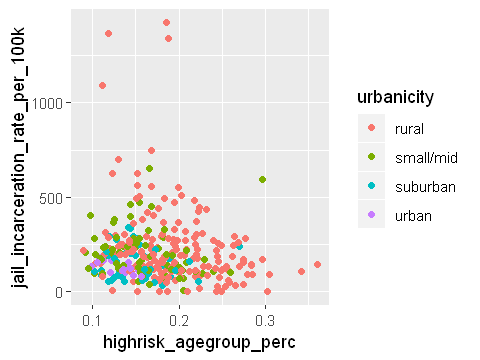

In [395]:
# try some plots
ggplot(jail_county_demographics_filtered_df, 
       aes( x = highrisk_agegroup_perc, y = jail_incarceration_rate_per_100k, color = urbanicity) ) + 
            geom_point()

## initial clustering

In [396]:
# column names
jail_county_demographics_columns <- data.frame( colindex = 1:31, colname = names(jail_county_demographics_df))
jail_county_demographics_columns

colindex,colname
1,date
2,county
3,state
4,jail_population
5,resident_population
6,cases
7,deaths
8,jail_incarceration_rate_per_100k
9,urbanicity
10,tot_pop


[1] 308  32

date,county,state,jail_population,resident_population,cases,deaths,jail_incarceration_rate_per_100k,urbanicity,tot_pop,...,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,highrisk_agegroup_perc,land_area,population_density,pop_infection_rate,cluster
2020-04-11,Inyo,California,24,18039,12,0,133.0,rural,17987,...,0.1650081,0.1288709,0.07043976,0.03474732,0.7659421,0.2340579,10180.88,1.766743,0.0006652253,3
2020-04-27,Summit,Ohio,388,541013,500,39,71.7,small/mid,541918,...,0.1453338,0.1039216,0.05124945,0.02425090,0.8205780,0.1794220,412.75,1312.944882,0.0009241922,3
2020-04-29,Ottawa,Ohio,49,40525,37,0,120.9,rural,40769,...,0.1739557,0.1452820,0.07549854,0.02936054,0.7498590,0.2501410,254.92,159.928605,0.0009130167,3


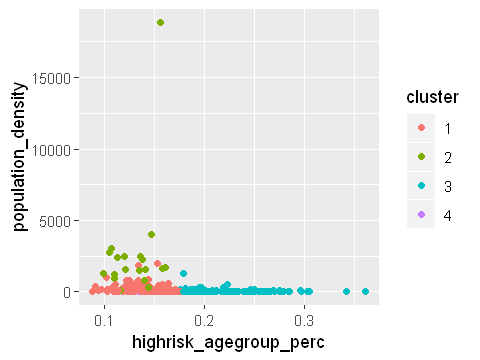

In [398]:
# k means

selected_column_indices <- c(4:8,10:31)
num_clusters <- 4

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)

dim(jail_county_demographics_filtered_df_dropna)

head(jail_county_demographics_filtered_df_dropna, 3)

options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

[1] "san mateo" "san diego" "baldwin"